# ブラックボックス最適化
数理モデルとして記述することが難しい関数に対しても何かしらの方法で最適化計算を行いたい時があります。
例えば、複雑なシミュレーションの結果や、物理実験の出力、あるいは内部構造が不明なレガシーシステムの応答などを最適化したい場合です。
このように、最適化したい関数の具体的な形が分からず、入力に対する出力値（評価値）しか得られない状況での最適化問題を**ブラックボックス最適化（Black Box Optimization, BBO）**と呼びます。

ブラックボックス最適化は、関数の内部情報を利用できないため、数理モデルを利用する数理最適化が適用できません。
そのため、評価値に基づいて効率的に最適解を探索する別の戦略が必要となります。

# OpenJijを用いたサロゲートベースBBO

OpenJijは、主にイジングモデルやQUBO（Quadratic Unconstrained Binary Optimization）といった組合せ最適化問題に特化したライブラリです。ブラックボックス最適化（BBO）においても、特に最適化したい変数がバイナリ変数である場合、OpenJijを活用するアプローチが考えられます。

ここで紹介するのは、QUBOをサロゲートモデル（代理モデル）として利用する BBOの手法です。基本的なアイデアは以下の通りです。

1. データ収集: ブラックボックス関数 f(x) に対して、いくつかの入力バイナリベクトル x とその出力 f(x) のペアを収集します。
2. サロゲートモデル構築 (QUBO推定): 収集した (x,f(x)) のデータセットを用いて、f(x) を最もよく近似するようなQUBOモデル E(x) を構築します。具体的には、QUBOの係数をデータセットに基づいて最適化します。
3. 最適化: QUBOモデル E(x) を用いて、最適化問題を解きます。これにより、E(x) の最小値を与えるバイナリベクトル x* を求めます。
4. 評価: x* を用いて、元のブラックボックス関数 f(x) を評価します。得られた f(x*) の値をデータセットに追加します。
5. 更新: 新たに得られた (x*, f(x*)) をデータセットに追加し、ステップ2に戻ってサロゲートモデル（QUBO）を更新します。これを繰り返すことで、徐々に f(x) の真の最小値を与える x に近づけていきます。
この手法は、特にバイナリ変数の最適化問題において、サロゲートモデルを用いることで探索空間を効率的に探索することが可能です。以下に、具体的な実装例を示します。

# QUBOの推定方法: Factorization Machine (FM)
ステップ2のQUBO推定には様々な方法が考えられます。QUBOの係数 QQijを未知数とみなせば、線形回帰のように解くこともできます。ここでは、より高度な手法としてFactorization Machine (FM) を利用します。Factorization Machineは、特徴量間の相互作用（特に二次の相互作用）を効率的に捉えることができるモデルです。FMによる予測値$\hat y(x)$は以下のように表されます。

$$\hat y(x) = w_0 + \sum_{i=1}^{n} w_i x_i + \sum_{i=1}^{n} \sum_{j=i+1}^{n} \braket{\vec{v}_i, \vec{v}_j} x_i x_j $$

ここで、$x = (x_1, x_2, \ldots, x_n)$ は入力特徴量ベクトル (今回はバイナリ変数) であり、
$w_0$はバイアス項、
$w_i$ は各特徴量の重み、$v_i$ は特徴量のベクトル表現です。FMは、特徴量間の相互作用を捉えるために、各特徴量に対して低次元のベクトルを割り当てます。これにより、二次の相互作用を効率的にモデル化することができます。

$|\vec v|=k$はFMのランクであり、$k$が大きいほどより多くの相互作用を捉えることができますが、過学習のリスクも高まります。FMは、特徴量間の相互作用を捉えるために、各特徴量に対して低次元のベクトルを割り当てます。これにより、二次の相互作用を効率的にモデル化することができます。

そのQUBOの推定にFactorization Machine (FM) を利用するBBO手法をプロセスは FM Annealing (FMA) と呼ばれることがあります。ここではFMAと呼ぶことにします。

## FMA実装に向けた準備

それでは、PyTorchを用いたFMとOpenJijのSAを組み合わせたFMAを実装します。ブラックボックス関数としては、ランダムに生成したQUBOのエネルギー計算を用いますが、FMAアルゴリズム自体はそのQUBO係数を知らないという設定で進めます。

In [1]:
import copy
import typing as typ

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as func
from tqdm.auto import trange


class FactorizationMachine(nn.Module):
    """Factorization Machine model

    ```math
    f(x|w, v) = w0 + Σwi*xi + ΣΣ<vj, vk>xj*xk
    = w0 + Σwi*xi + 1/2*(Σ(vi*xi)^2 - Σ(vi^2*xi^2))
    ```

    """

    def __init__(self, n_features: int, latent_dim: int):
        """Factroization Machine model

        Args:
            n_features (int): dimension of input features
            latent_dim (int): dimension of latent space
        """
        super(FactorizationMachine, self).__init__()
        self.n_features = n_features
        self.latent_dim = latent_dim

        # weight of 1st order terms
        self.linear = nn.Linear(n_features, 1, bias=True)
        # weight of 2nd order terms
        self.quad = nn.Parameter(torch.randn(n_features, latent_dim) / latent_dim)

    def forward(self, x):
        linear_terms = self.linear(x)

        square_of_sum = torch.pow(torch.matmul(x, self.quad), 2)
        sum_of_square = torch.matmul(x**2, self.quad**2)
        quad_terms = 0.5 * torch.sum(square_of_sum - sum_of_square, dim=1, keepdim=True)

        return linear_terms + quad_terms

    @property
    def v(self):
        return self.quad

    @property
    def w(self):
        return self.linear.weight

    @property
    def w0(self):
        return self.linear.bias


class FMTrainer:
    def __init__(
        self,
        n_features: int,
        latent_dim: int,
        optimizer_params: typ.Optional[dict] = None,
    ):
        self.model = FactorizationMachine(n_features, latent_dim)
        if optimizer_params is None:
            self.optimizer = torch.optim.AdamW(self.model.parameters())
        else:
            self.optimizer = torch.optim.AdamW(
                self.model.parameters(), **optimizer_params
            )
        self._x_numpy = np.array([])
        self._y_numpy = np.array([])

    def fit(self, x_numpy: np.ndarray, y_numpy: np.ndarray, n_epochs: int):
        x = torch.tensor(x_numpy, dtype=torch.float32)
        y = torch.tensor(y_numpy, dtype=torch.float32).view(-1, 1)
        dataset = torch.utils.data.TensorDataset(x, y)
        train_set, test_set = torch.utils.data.random_split(dataset, (0.8, 0.2))
        train_loader = torch.utils.data.DataLoader(
            train_set, batch_size=8, shuffle=True
        )
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=8, shuffle=True)

        # 学習の実行
        min_loss = 1e18  # 損失関数の最小値を保存
        best_state = self.model.state_dict()  # モデルの最も良いパラメータを保存
        for _ in trange(n_epochs, leave=False):
            for x_batch, y_batch in train_loader:
                self.optimizer.zero_grad()
                y_pred = self.model(x_batch)
                loss = func.mse_loss(y_pred, y_batch)
                loss.backward()
                self.optimizer.step()

            # Early Stopping
            patience = 10  # 我慢するエポック数
            min_loss = float("inf")
            patience_counter = 0
            with torch.no_grad():
                for x_batch, y_batch in test_loader:
                    y_pred = self.model(x_batch)
                    loss = func.mse_loss(y_pred, y_batch)

                    if loss < min_loss:
                        min_loss = loss
                        patience_counter = 0
                        best_state = copy.deepcopy(self.model.state_dict())
                    else:
                        patience_counter += 1
            if patience_counter > patience:
                break
        self.model.load_state_dict(best_state)

    def predict(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    @property
    def x(self):
        return self._x_numpy

    @property
    def y(self):
        return self._y_numpy

    def get_qubo(self) -> tuple[np.ndarray, float]:
        w = self.model.linear.weight.data.numpy().flatten()
        w0 = self.model.linear.bias.data.numpy().flatten()
        q = np.diag(w)
        v = self.model.quad.data.numpy()
        # <vi, vj> = Σ_f v_if * v_jf
        # (v @ v.T)_ij = Σ_f v_if * v_jf
        vv = v @ v.T
        vv = vv - np.diag(np.diag(vv))
        q += 1 / 2 * vv
        return q, float(w0)

### ランダムQUBOの実装

ここでは、ランダムQUBOのエネルギー計算を行う関数を定義します。ここではこのQUBOをアルゴリズム側では知らないとして進めます。

In [2]:
# --- ブラックボックス関数の定義 ---
# (最適化アルゴリズムはこの内部を知らないという想定)


N = 40  # 変数の数
# ランダムなQUBOを生成 (これが真の目的関数)
class QuadraticBlackboxFunc:
    def __init__(self, n: int, random_seed: int = 0):
        self.random_state = np.random.RandomState(random_seed)
        Q = self.random_state.uniform(-0.5, 1, (n, n))
        self.Q = (Q + Q.T) / 2
        self.Q[np.abs(self.Q) < 0.08] = 0.0

        noise_variance = 0.1
        num_vars = n
        self.noise_variance = noise_variance
        self.rng = np.random.default_rng(random_seed)
        self.Q = self.rng.normal(0, 1, size=(num_vars, num_vars))

    def __call__(self, x: np.ndarray) -> float:
        return x @ self.Q @ x

black_box_function = QuadraticBlackboxFunc(N, random_seed=0)

### FMAのパラメータ設定

In [3]:
# --- FMA設定 ---
num_total_evaluations = 80  # ブラックボックス関数の総評価回数
num_initial_points = 30  # 初期ランダムサンプリング数
k_fm = 10  # Factorization Machine の因子ベクトルの次元 (k)
fm_learning_rate = 0.01
fm_epochs_per_iteration = 50  # 各FMA反復でのFM学習エポック数
num_reads_sa = 50  # OpenJij SA の num_reads

In [4]:
fm_trainer = FMTrainer(N, k_fm, {"lr": fm_learning_rate})

### 初期データセットの生成

In [5]:
# --- 初期データ収集 ---
n = N
num_init = num_initial_points

quad_bf = QuadraticBlackboxFunc(n)

X_init = np.random.choice([0, 1], (num_init, n))
y_init = np.array([quad_bf(x) for x in X_init])

## FMAの実装と実行

In [6]:
import openjij as oj


def solver(Q):
    _Q, _ = Q
    sampler = oj.SASampler()
    response = sampler.sample_qubo(_Q, num_reads=100)
    return response.lowest().states[0]

In [7]:
dataset_X = X_init
dataset_y = y_init
for i in range(num_initial_points):
    fm_trainer.fit(dataset_X, dataset_y, n_epochs=fm_epochs_per_iteration)
    Q, w0 = fm_trainer.get_qubo()
    x = solver((Q, w0))
    y = black_box_function(x)
    dataset_X = np.vstack([dataset_X, x])
    dataset_y = np.hstack([dataset_y, y])
    print(f"FM: {x} -> {y}")


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 1 0 0 1 1 0 1 1 1 1 0 1 1 1 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1
 1 1 1] -> -37.933205585134466


/var/folders/75/kxv4q45s3vv21rqmyth9036w0000gn/T/ipykernel_96754/2265195906.py:137: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return q, float(w0)


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 1 1 0 1 1 0 1 1 0 1 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1] -> -33.523388811142325


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1
 1 1 1] -> -50.61952430051983


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1
 1 1 1] -> -50.61952430051983


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1
 1 1 1] -> -50.61952430051983


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1
 1 1 1] -> -50.61952430051983


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1
 1 1 1] -> -50.61952430051983


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1
 1 1 1] -> -50.61952430051983


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1
 1 1 1] -> -50.61952430051983


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1
 1 1 1] -> -50.61952430051983


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1
 1 1 1] -> -50.61952430051983


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1
 1 1 1] -> -50.61952430051983


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1
 1 1 1] -> -50.61952430051983


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1
 1 1 1] -> -50.61952430051983


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1
 1 1 1] -> -50.61952430051983


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1
 1 1 1] -> -50.61952430051983


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1
 1 1 1] -> -50.61952430051983


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1
 1 1 1] -> -50.61952430051983


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1
 1 1 1] -> -50.61952430051983


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1
 1 1 1] -> -50.61952430051983


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1
 1 1 1] -> -50.61952430051983


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1
 1 1 1] -> -50.61952430051983


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1
 1 1 1] -> -50.61952430051983


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1
 1 1 1] -> -50.61952430051983


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1
 1 1 1] -> -50.61952430051983


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1
 1 1 1] -> -50.61952430051983


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1
 1 1 1] -> -50.61952430051983


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1
 1 1 1] -> -50.61952430051983


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1
 1 1 1] -> -50.61952430051983


  0%|          | 0/50 [00:00<?, ?it/s]

FM: [1 1 1 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1
 1 1 1] -> -50.61952430051983


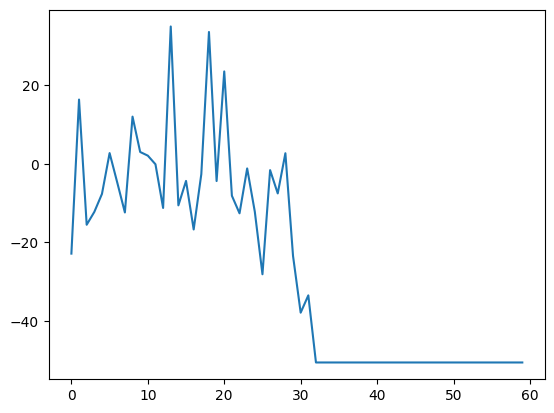

In [9]:
import matplotlib.pyplot as plt

plt.plot(dataset_y)